# Docstring
This project used to predict volatility of stocks's price on Vietnamese index, consist of: FPT, MSN, PNJ, VIC.

## Requirements

## Data Files

# Implementation

## Import Libraries

In [18]:
import os
import sys
import glob
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import torch
import talib
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mplfinance as fplt

from datetime import datetime
from typing import Mapping, List, Optional, Iterable
from copy import copy
from torch import optim
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from dataclasses import dataclass, field
from pathlib import Path


# from src.data.dataset import StockDataset, StocksDatasetConfig
# from src.model.model import VolatilityPredictor, VolatilityPredictorConfig 
# from src.utils.training import Trainer

## Define Custom Classes

### Normalizer

In [6]:
class OutlierClipper:
    def __init__(self, config):
        self.config = config
        self.lower_bound: float = None
        self.upper_bound: float = None
        self.scalers: Mapping[str, MinMaxScaler] = dict()

    def fit(
        self,
        df: pd.DataFrame
    ):

        for col in self.config.outlier_cols:
            q0, q1, q2, q3, q4 = np.percentile(
                df.loc[:, [col]].values,
                method='midpoint', axis=0, q=[0, 25, 50, 75, 100],
            )

            IQR = q3 - q1
            self.lower_bound = q1 - 1.5 * IQR
            self.upper_bound = q3 + 1.5 * IQR
            df.loc[:, f'clipped_{col}'] = np.clip(
                a=df.loc[:, col].values,
                a_min=self.lower_bound, a_max=self.upper_bound
            )
            scaler = MinMaxScaler((0, 1))
            scaler.fit(df.loc[:, [f'clipped_{col}']])
            self.scalers[col] = scaler

    def __call__(self, df: pd.DataFrame):
        for col in self.config.outlier_cols:
            tmp_value = self.scalers[col].transform(df.loc[:, [f'clipped_{col}']])
            df.drop(columns=[col], inplace=True)
            df.loc[:, [col]] = tmp_value


class Normalizer:
    def __init__(self, config):
        self.config = config
        self.normalizers: Mapping[(str, str), MinMaxScaler] = dict()
        self.clippers: Mapping[str, OutlierClipper] = dict()

    def fit(
            self,
            df: pd.DataFrame,
            ticker: str
    ):
        clipper = OutlierClipper(config=self.config)
        clipper.fit(df=df)
        self.clippers[ticker] = clipper
        for col in self.config.normal_cols:
            scaler = MinMaxScaler((0, 1))
            scaler.fit(X=df.loc[:, [col]])
            self.normalizers[(ticker, col)] = scaler

    def __call__(
            self,
            df: pd.DataFrame,
            ticker: str,
            **kwargs
    ):
        copy_df: pd.DataFrame = copy(df)
        self.clippers[ticker](copy_df)
        for col in self.config.normal_cols:
            scaler = self.normalizers[(ticker, col)]
            copy_df.loc[:, col] = scaler.transform(copy_df.loc[:, [col]])

        return copy_df

### Dataset

In [19]:
@dataclass
class StocksDatasetConfig:

    load_ensemble: Optional[bool] = field(
        default=True,
        metadata='Load data from csv files.'
    )

    dataset_dir: Optional[str] = field(
        default=os.path.join(os.getcwd(), 'data', 'raw'),
        metadata='Directory contains csv files.'
    )

    pre_fields: Optional[List[str]] = field(
        default_factory=lambda: ['Ticker', 'Date/Time', 'Open', 'Close', 'Low', 'High', 'Volume'],
        metadata='Needing fields to pre-process.',
    )

    post_fields: Optional[List[str]] = field(
        default_factory=lambda: ['open', 'low', 'high', 'EMA', 'SMA',  'volume'],
        metadata="Needing field take to train model."
    )

    normal_cols: Optional[List[str]] = field(
        default_factory=lambda: ['open', 'high', 'low', 'EMA', 'SMA']
    )

    outlier_cols: Optional[List[str]] = field(
        default_factory=lambda: ['volume']
    )

    target_field: Optional[str] = field(
        default_factory=lambda: ['close'],
        metadata='Field used to as target.'
    )

    averaging_fields: Optional[List[str]] = field(
        default_factory=lambda: ['EMA', 'SMA'],
        metadata='Additional averaging indices.'
    )

    separate_ticker: Optional[bool] = field(
        default=True,
        metadata='Separate stock price per ticker.'
    )

    unit: Optional['str'] = field(
        default='min',
        metadata='Unit of time being consider, \'second\', \'min\', \'hour\', \'day\'.',
    )

    timeperiod: Optional[int] = field(
        default=15,
        metadata="Number of last 'unit' price at current time."
    )

    full_dataset: Optional[bool] = field(
        default=True,
        metadata='Indicate that dataset is full, which is split into train, val, test set,'
    )

    data_raw: Optional[bool] = field(
        default=True,
        metadata='Indicate that dataset is raw, which is loaded from files.'
    )

    dtype: Optional[torch.dtype] = field(
        default=torch.float32,
        metadata='Dtype for dataset.'
    )

class StockDataset(Dataset):
    def __init__(self, config: StocksDatasetConfig, df: pd.DataFrame=None):
        super().__init__()
        self.config = config
        self.df: pd.DataFrame = None
        self.sample_df: pd.DataFrame = None
        self.normalizer = Normalizer(config=self.config)

        if not self.config.data_raw:
            self.sample_df = df
        else:
            if self.config.load_ensemble:
                self.df: pd.DataFrame = self.load_ensemble_data_csv()
            else:
                self.df = df
            self.pre_process()

    def __len__(self):
        return len(self.sample_df)

    def __getitem__(self, idx: int):
        sample = self.sample_df.loc[idx, :].values
        return torch.tensor(sample[0]).to(self.config.dtype), torch.tensor(sample[1]).to(self.config.dtype)

    def load_data_csv(
            self,
            csv_path: str,
    ):
        df = pd.read_csv(
            filepath_or_buffer=csv_path,
            header=0,
            delimiter=',',
        )

        columns = df.columns
        common_fields = set(columns).intersection(self.config.pre_fields)
        assert common_fields, "No any needing field."

        return df.loc[:, list(common_fields)]

    def load_ensemble_data_csv(self):
        csv_paths = glob.glob(f"{self.config.dataset_dir}/*.csv")
        dfs = [self.load_data_csv(csv_path) for csv_path in csv_paths]
        return pd.concat(dfs, axis=0, ignore_index=True,)

    def pre_process(self):
        # Rename columns to lower case
        self.df.columns = self.df.columns.map(mapper=str.lower)

        # Date form YYYY/MM/DD HH:mm:SS
        self.df['date_time'] = pd.to_datetime(self.df['date/time'])
        # Timestamp in second
        self.df['timestamp'] = self.df['date_time'].apply(lambda x: x.timestamp())

        if self.config.unit == 'min':
            duration = 60
            unit = 'm'
        elif self.config.unit == 'hour':
            duration = 3600
            unit = 'h'
        elif self.config.unit == 'day':
            duration = 24*3600
            unit = 'D'
        else:
            duration = 1
            unit = 's'

        # Timestamp form unit
        self.df[f'timestamp_{self.config.unit}'] = (self.df['timestamp'] // duration).convert_dtypes('int')
        # Date form unit
        self.df['date/time'] = self.df[f'timestamp_{self.config.unit}'].apply(lambda x: pd.to_datetime(x, unit=unit))

        ticker_dfs = []
        for ticker in self.df['ticker'].unique():
            index = self.df['ticker'] == ticker
            ticker_df: pd.DataFrame = self.df.loc[index, :]
            ticker_df = ticker_df.sort_values(
                by=[f"timestamp_{self.config.unit}", "timestamp"],
                ascending=True, ignore_index=True, inplace=False
            )

            ticker_df['unit_return'] = ticker_df['close'].pct_change(periods=1)

            if self.config.averaging_fields:
                self._add_averaging_index(df=ticker_df)
                ticker_df.fillna(value=0, inplace=True)

            self.normalizer.fit(
                df=ticker_df,
                ticker=ticker,
            )
            ticker_dfs.append(ticker_df)

        self.df = pd.concat(ticker_dfs, ignore_index=True, axis=0)
        self.df.index = self.df.loc[:, 'date_time']
        self.df.drop(columns=['date_time'], inplace=True, axis=1)

    def split(
            self,
            train_ratio: float,
            val_ratio: float
    ) -> Iterable[Dataset]:
        if not self.config.data_raw:
            raise ValueError('Data is already sub-set, no need split.')

        train_dfs, val_dfs, test_dfs, sample_dfs = [], [], [], []
        for ticker in self.df['ticker'].unique():
            index = self.df['ticker'] == ticker
            ticker_df: pd.DataFrame = self.df.loc[index, :]

            ticker_df = self.normalizer(
                df=ticker_df,
                ticker=ticker
            )

            if self.config.data_raw:
                ticker_df = self._generate_timeseries(df=ticker_df)
            sample_dfs.append(ticker_df)

            ticker_train_df, ticker_val_df, ticker_test_df = self._split_df(
                ticker_df,
                train_ratio=train_ratio,
                val_ratio=val_ratio
            )
            train_dfs.append(ticker_train_df)
            val_dfs.append(ticker_val_df)
            test_dfs.append(ticker_test_df)

        if self.config.full_dataset:
            self.sample_df = pd.concat(sample_dfs, ignore_index=True, axis=0)

        train_df = pd.concat(train_dfs, axis=0, ignore_index=True)
        val_df = pd.concat(val_dfs, axis=0, ignore_index=True)
        test_df = pd.concat(test_dfs, axis=0, ignore_index=True)

        self.config.data_raw = False
        sub_dataset_config = StocksDatasetConfig(
            load_ensemble=False,
            data_raw=False,
            full_dataset=False,
        )
        train_dataset = StockDataset(config=sub_dataset_config, df=train_df)
        val_dataset = StockDataset(config=sub_dataset_config, df=val_df)
        test_dataset = StockDataset(config=sub_dataset_config, df=test_df)

        return train_dataset, val_dataset, test_dataset

    def _generate_timeseries(
            self,
            df: pd.DataFrame
    ) -> pd.DataFrame:
        fields = set(df.columns).intersection(set(self.config.post_fields))
        assert fields
        fields = list(fields)
        values = df.loc[:, fields].values
        values = np.pad(array=values, pad_width=((self.config.timeperiod-1, 0), (0, 0)), constant_values='0')
        targets = df.loc[:, self.config.target_field].values
        windows = []
        for i in range(0, len(values) - self.config.timeperiod,1):
            window = values[i:i+self.config.timeperiod, ...]
            windows.append((window, targets[i]))

        sample_df = pd.DataFrame(data=windows, columns=['input', 'output'])

        return sample_df

    def _split_df(
            self,
            df: pd.DataFrame,
            train_ratio: float = 0.0,
            val_ratio: float = 0.0
    ) -> Iterable[pd.DataFrame]:
        df = df.sample(frac=1).reset_index(drop=True)
        train_length: int = int(train_ratio * len(df))
        val_length: int = int(val_ratio * len(df))
        test_length: int = len(df) - train_length - val_length

        if train_length > 0:
            train_df: pd.DataFrame = df.iloc[:train_length, :].reset_index(drop=True)
        else:
            train_df = None

        if val_length > 0:
            val_df: pd.DataFrame = df.iloc[train_length:-test_length, :].reset_index(drop=True)
        else:
            val_df = None

        if test_length > 0 and val_length > 0:
            test_df: pd.DataFrame = df.iloc[-test_length:, :].reset_index(drop=True)
        else:
            test_df = None

        return train_df, val_df, test_df

    def _add_averaging_index(
            self,
            df: pd.DataFrame
    ):
        if "EMA" in self.config.averaging_fields:
            df['EMA'] = talib.EMA(df.loc[:, 'close'], timeperiod=self.config.timeperiod)
        if "SMA" in self.config.averaging_fields:
            df['SMA'] = talib.SMA(df.loc[:, 'close'], timeperiod=self.config.timeperiod)
        if "RSI" in self.config.averaging_fields:
            df['RSI'] = talib.RSI(df.loc[:, 'close'], timeperiod=self.config.timeperiod)

### Model

In [8]:
torch.manual_seed(123)

@dataclass
class VolatilityPredictorConfig:

    input_dim: Optional[int] = field(
        default=6,
        metadata='Dimension of input vector.'
    )
    up_projection: Optional[int] = field(
        default=12,
        metadata="Up projection input vector."
    )

    up_projection_bias: Optional[bool] = field(
        default=True,
        metadata='Add bias when up projection.'
    )

    lstm_dim: Optional[int] = field(
        default=64,
        metadata="Dimension of hidden."
    )

    lstm_bias: Optional[bool] = field(
        default=True,
        metadata='Add bias when comput lstm.'
    )

    proj_size: Optional[int] = field(
        default=0,
        metadata='Project size of lstm.'
    )

    is_bidirectional: Optional[bool] = field(
        default=False,
        metadata="Compute back to head when conpute lsmt."
    )

    num_lstm: Optional[int] = field(
        default=2,
        metadata="Number of stacking lstm."
    )

    down_projection: Optional[int] = field(
        default=32,
        metadata='Final vector dim before compute logits.'
    )

    down_projection_bias: Optional[bool] = field(
        default=True,
        metadata='Add bias when down projection.'
    )

    final_projection: Optional[int] = field(
        default=1,
        metadata='Dimension of logits.'
    )

    final_projection_bias: Optional[bool] = field(
        default=True,
        metadata='Add bias when final projection.'
    )   

    device: Optional[str] = field(
        default='cpu',
        metadata='Device put model and data.'
    )

    dtype: Optional[object] = field(
        default=torch.float32,
        metadata="Dtype of model's parameters."
    )


class VolatilityPredictor(nn.Module):
    
    def __init__(self, config: VolatilityPredictorConfig, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.config = config
        
        self.up_projection = nn.Linear(
            in_features=self.config.input_dim,
            out_features=self.config.up_projection,
            bias=self.config.up_projection_bias,
            device=self.config.device,
            dtype=self.config.dtype,
        )

        self.relu1 = nn.ReLU(inplace=False)

        self.lstm = nn.LSTM(
            input_size=self.config.up_projection,
            hidden_size=self.config.lstm_dim,
            num_layers=self.config.num_lstm,
            bidirectional=self.config.is_bidirectional,
            batch_first=True,
            bias=self.config.lstm_bias,
            proj_size=self.config.proj_size,
            device=self.config.device,
            dtype=self.config.dtype,
        )

        self.lstm_dim = self.config.lstm_dim if self.config.proj_size <= 0 else self.config.proj_size

        self.down_projection = nn.Linear(
            in_features=self.lstm_dim,
            out_features=self.config.down_projection,
            bias=self.config.down_projection_bias,
            device=self.config.device,
            dtype=self.config.dtype,
        )

        self.relu2 = nn.ReLU()

        self.final_projection = nn.Linear(
            in_features=self.config.down_projection,
            out_features=self.config.final_projection,
            bias=self.config.final_projection_bias,
            device=self.config.device,
            dtype=self.config.dtype,
        )

    def forward(self, x: torch.Tensor):
        x = self.up_projection(x)
        x = self.relu1(x)
        x, (hn, cn) = self.lstm(x[:, -1, :])
        x = self.down_projection(x)
        x = self.relu2(x)
        logits = self.final_projection(x)

        return logits

### Trainer

In [34]:
class Trainer:
    def __init__(
            self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            test_loader: DataLoader,
            loss_fn,
            optimizer,
            writer_path: str,
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.writer_path = writer_path

    def run(
            self,
            epoch: int,
    ):
        timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
        writer = SummaryWriter('{}_{}'.format(self.writer_path,timestamp))
        epoch_number = 0

        best_vloss = 1_000_000.

        for epoch in range(epoch):
            print('EPOCH {}:'.format(epoch_number + 1))

            self.model.train(True)
            avg_loss = self.train_one_epoch(epoch_number, writer)

            running_vloss = 0.0
            self.model.eval()

            with torch.no_grad():
                for i, vdata in enumerate(self.val_loader):
                    vinputs, vlabels = vdata
                    voutputs = self.model(vinputs)
                    vloss = self.loss_fn(voutputs, vlabels)
                    running_vloss += vloss

            avg_vloss = running_vloss / (i + 1)
            print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

            writer.add_scalars(
                main_tag='Training vs. Validation Loss',
                tag_scalar_dict={'Training': avg_loss, 'Validation': avg_vloss},
                global_step=epoch_number + 1
            )
            writer.flush()

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                model_path = 'model_epoch_{}_{}'.format(timestamp, epoch_number)
                torch.save(self.model.state_dict(), model_path)

            epoch_number += 1

    def train_one_epoch(
            self,
            epoch_index,
            tb_writer
    ):
        running_loss = 0.
        last_loss = 0.

        for i, data in enumerate(self.train_loader):
            inputs, targets = data

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            loss.backward()

            self.optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 999:
                last_loss = running_loss / 1000  # loss per batch
                print(' batch {} loss: {}'.format(i + 1, last_loss))
                tb_x = epoch_index * len(self.train_loader) + i + 1
                tb_writer.add_scalar('Loss/train',last_loss,tb_x)
                running_loss = 0.

        return last_loss

## Initialize Dataset

In [20]:
dataset_config = StocksDatasetConfig(unit='min', timeperiod=30)
dataset = StockDataset(config=dataset_config)

## About Dataset

In [21]:
dataset.df.head(100)

,high,ticker,volume,date/time,open,close,low,timestamp,timestamp_min,unit_return,EMA,SMA,clipped_volume
date_time,,,,,,,,,,,,,
2018-10-17 09:39:00,98.5,VIC,390,2018-10-17 09:39:00,98.5,98.5,98.5,1.539769e+09,25662819,0.000000,0.000000,0.000000,390.0
2018-10-17 09:40:00,98.5,VIC,760,2018-10-17 09:40:00,98.5,98.5,98.5,1.539769e+09,25662820,0.000000,0.000000,0.000000,760.0
2018-10-17 09:41:00,98.6,VIC,2060,2018-10-17 09:41:00,98.6,98.6,98.6,1.539769e+09,25662821,0.001015,0.000000,0.000000,2060.0
2018-10-17 09:42:00,98.6,VIC,5540,2018-10-17 09:42:00,98.6,98.6,98.6,1.539769e+09,25662822,0.000000,0.000000,0.000000,5540.0
2018-10-17 09:43:00,98.7,VIC,760,2018-10-17 09:43:00,98.6,98.7,98.6,1.539769e+09,25662823,0.001014,0.000000,0.000000,760.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-17 13:00:00,98.6,VIC,14000,2018-10-17 13:00:00,98.6,98.6,98.6,1.539781e+09,25663020,-0.001013,98.594235,98.553333,7155.0
2018-10-17 13:01:00,98.6,VIC,1770,2018-10-17 13:01:00,98.6,98.6,98.6,1.539781e+09,25663021,0.000000,98.594607,98.556667,1770.0
2018-10-17 13:02:00,98.7,VIC,310,2018-10-17 13:02:00,98.7,98.6,98.6,1.539781e+09,25663022,0.000000,98.594955,98.556667,310.0


In [22]:
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 459335 entries, 2018-10-17 09:39:00 to 2020-12-22 14:46:00
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   high            459335 non-null  float64       
 1   ticker          459335 non-null  object        
 2   volume          459335 non-null  int64         
 3   date/time       459335 non-null  datetime64[ns]
 4   open            459335 non-null  float64       
 5   close           459335 non-null  float64       
 6   low             459335 non-null  float64       
 7   timestamp       459335 non-null  float64       
 8   timestamp_min   459335 non-null  Int64         
 9   unit_return     459335 non-null  float64       
 10  EMA             459335 non-null  float64       
 11  SMA             459335 non-null  float64       
 12  clipped_volume  459335 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(9), int64(1), o

In [23]:
dataset.df.describe()

,high,volume,date/time,open,close,low,timestamp,timestamp_min,unit_return,EMA,SMA,clipped_volume
count,459335.000000,4.593350e+05,459335,459335.000000,459335.000000,459335.000000,4.593350e+05,459335.0,459335.000000,459335.000000,459335.000000,459335.000000
mean,74.626579,4.909390e+03,2019-10-09 03:44:05.685392896,74.545826,74.546183,74.481065,1.570593e+09,26176544.094757,0.000014,74.527035,74.527038,3376.982988
min,30.250000,1.000000e+00,2017-12-25 09:15:00,30.250000,30.250000,30.220000,1.514193e+09,25236555.0,-0.072055,0.000000,0.000000,1.000000
25%,54.250000,3.600000e+02,2019-03-08 10:31:00,54.190000,54.190000,54.150000,1.552041e+09,25867351.0,0.000000,54.176576,54.177333,360.000000
50%,75.920000,1.500000e+03,2019-11-05 14:22:00,75.730000,75.720000,75.600000,1.572964e+09,26216062.0,0.000000,75.723168,75.743333,1500.000000
75%,90.200000,4.920000e+03,2020-06-08 10:49:00,90.100000,90.100000,90.000000,1.591613e+09,26526889.0,0.000000,90.138370,90.133333,4920.000000
max,126.500000,3.300680e+06,2020-12-22 14:46:00,126.100000,126.500000,126.100000,1.608648e+09,26810806.0,0.091371,125.799128,125.883333,21275.000000
std,23.038201,1.902104e+04,NaN,23.023346,23.024380,23.011619,2.459742e+07,409957.031788,0.005042,23.048694,23.049314,4462.337370


## Visualize Dataset

In [24]:
tickers = dataset.df['ticker'].unique()

### Plot close price of each ticker

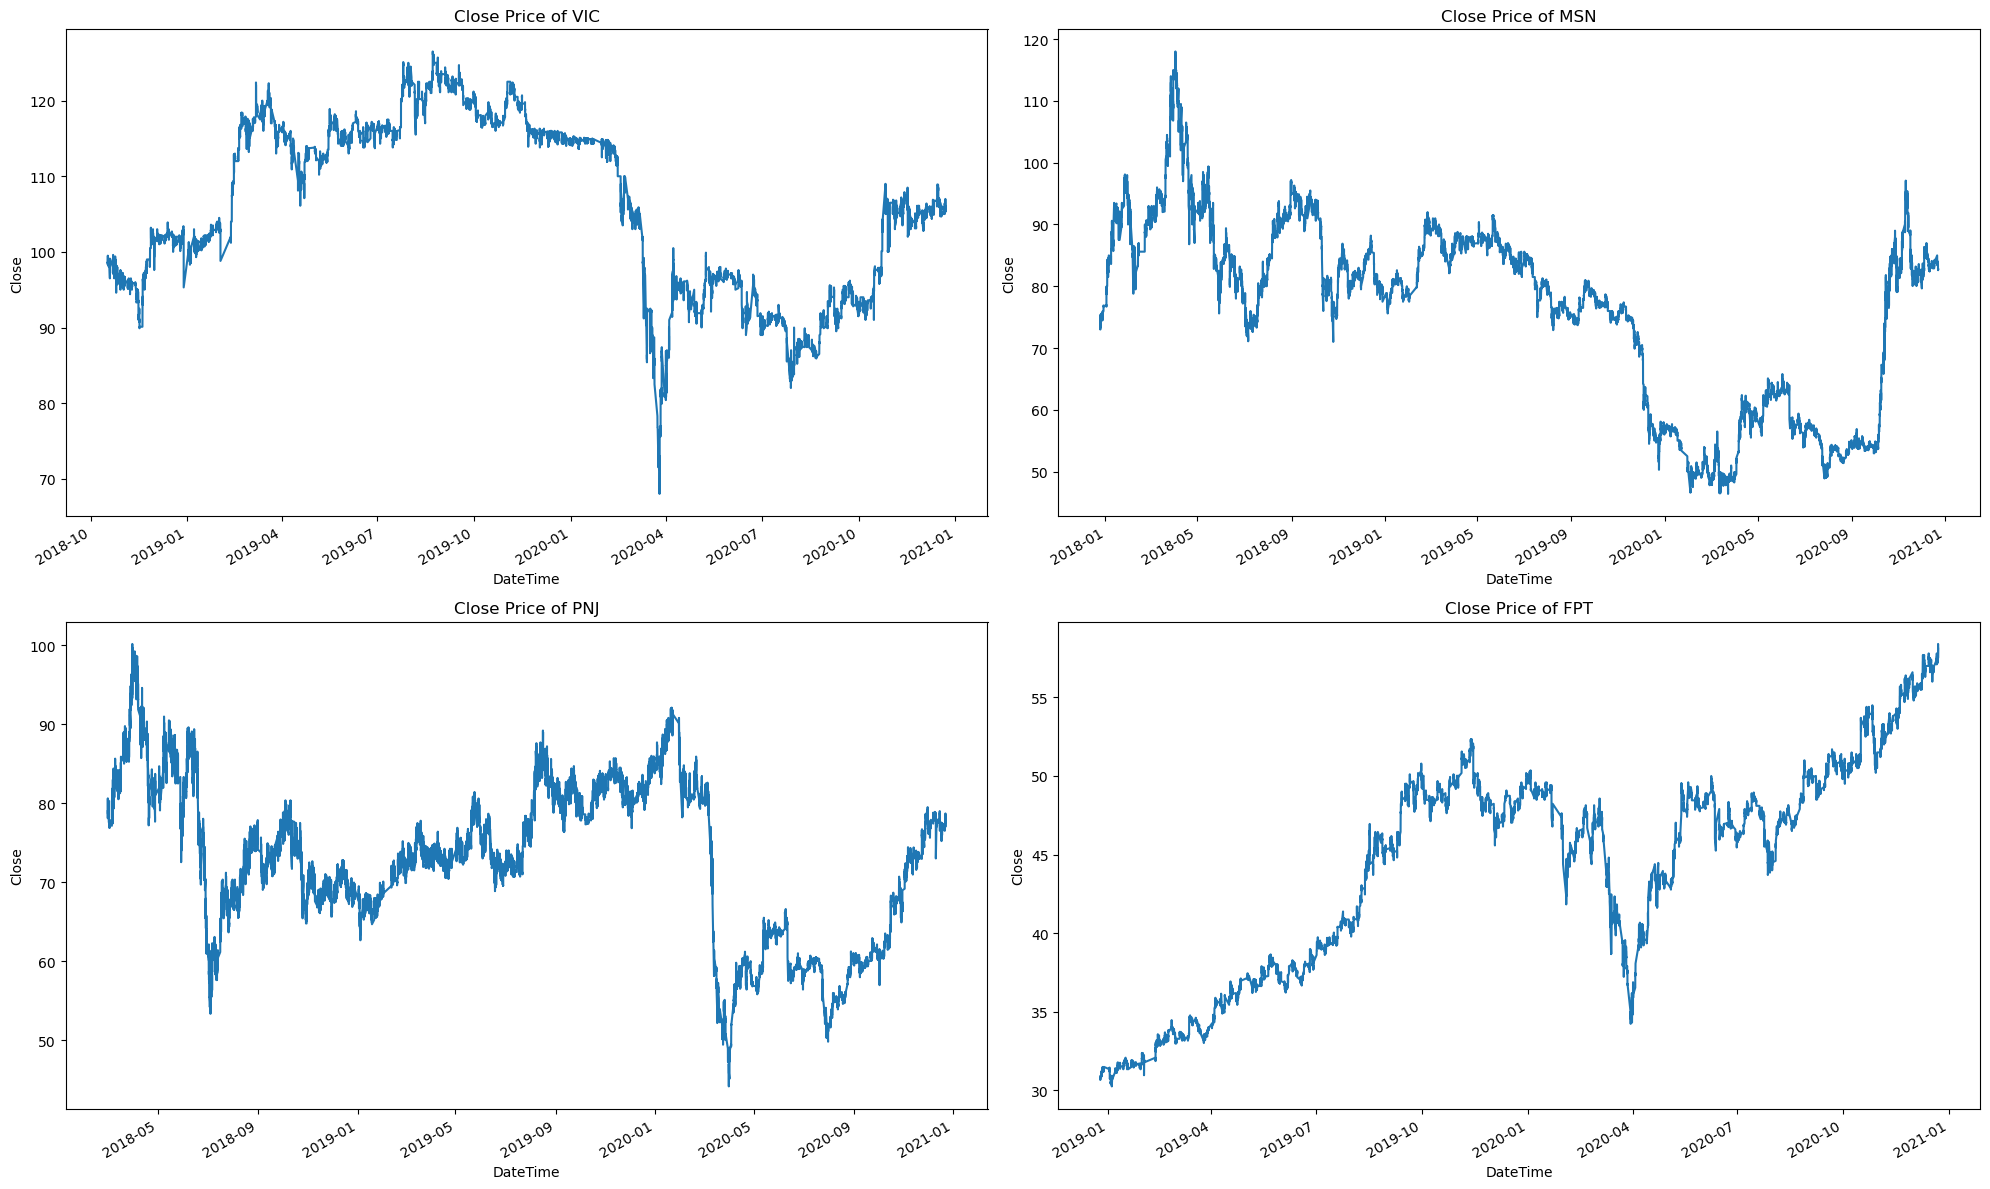

In [25]:
plt.figure(figsize=(20, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 2, i)
    index = dataset.df['ticker'] == ticker
    dataset.df.loc[index, 'close'].plot()
    plt.ylabel('Close')
    plt.xlabel('DateTime')
    plt.title(f"Close Price of {ticker}")
    
plt.tight_layout()

### Plot close price with MA index.

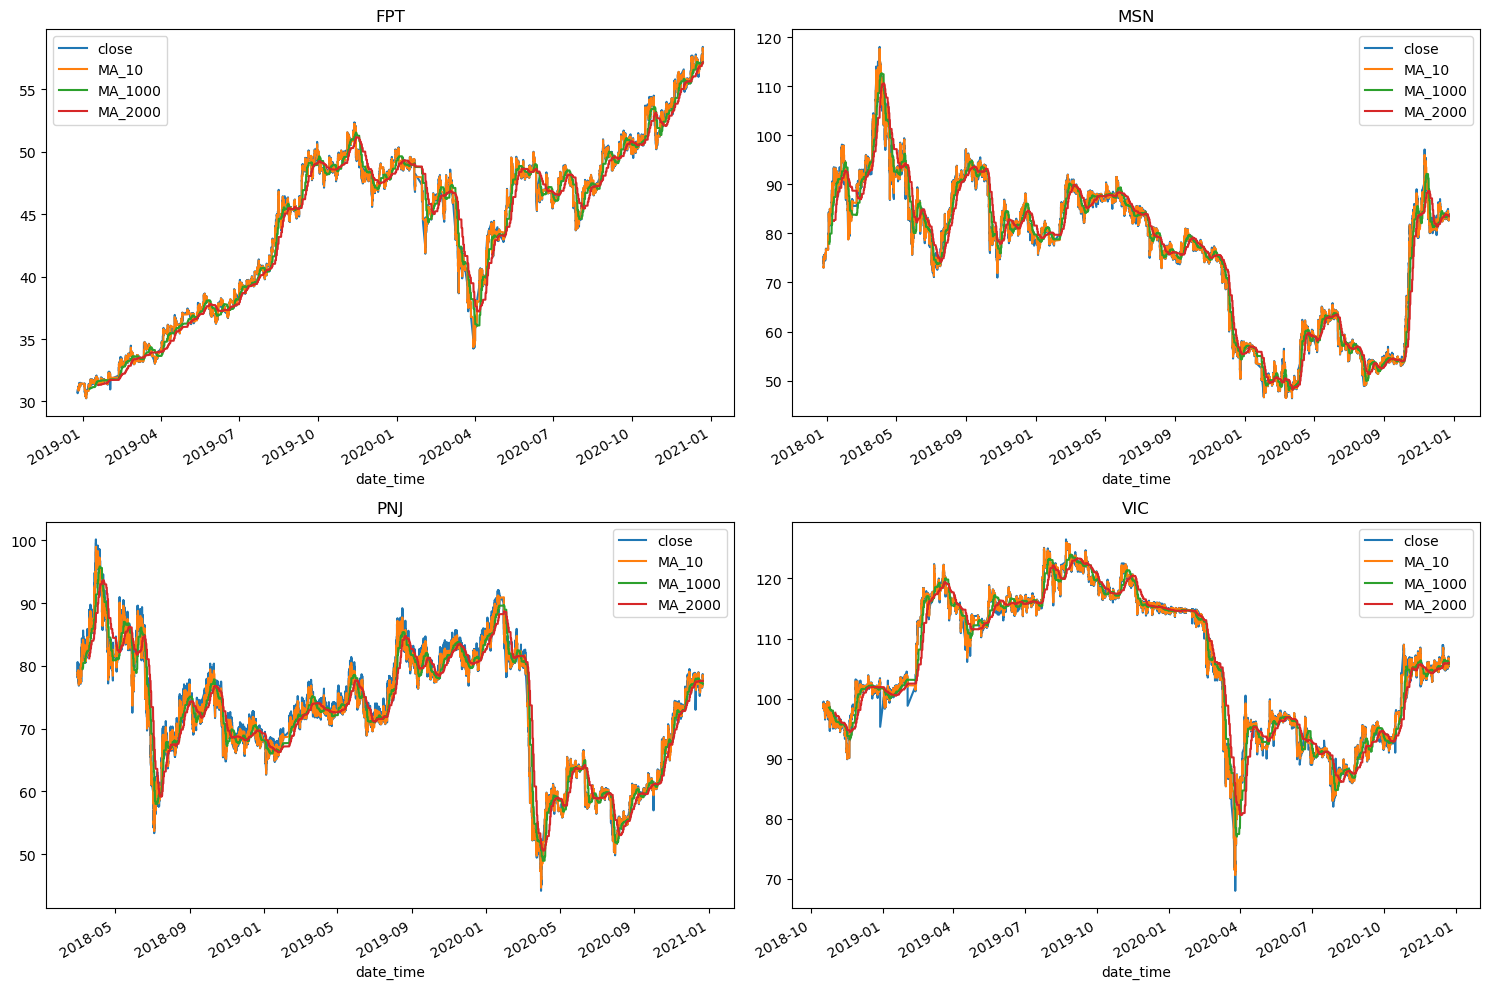

In [8]:
copy_df = copy(dataset.df)

ma_day = [10, 1000, 2000]
ticker_d = dict()
for ticker in tickers:
    ma_cols = []
    for ma in ma_day:
        index = copy_df['ticker'] == ticker
        column_name = f"MA_{ma}"
        copy_df.loc[index, column_name] = copy_df.loc[index, 'close'].rolling(ma).mean()
        ma_cols.append(column_name)
    ticker_d[ticker] = copy_df.loc[index, ['close']+ma_cols]

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)


ticker_d['FPT'].plot(ax=axes[0,0])
axes[0,0].set_title('FPT')

ticker_d['MSN'].plot(ax=axes[0,1])
axes[0,1].set_title('MSN')

ticker_d['PNJ'].plot(ax=axes[1,0])
axes[1,0].set_title('PNJ')

ticker_d['VIC'].plot(ax=axes[1,1])
axes[1,1].set_title('VIC')

fig.tight_layout()

### Boxplot of avergings

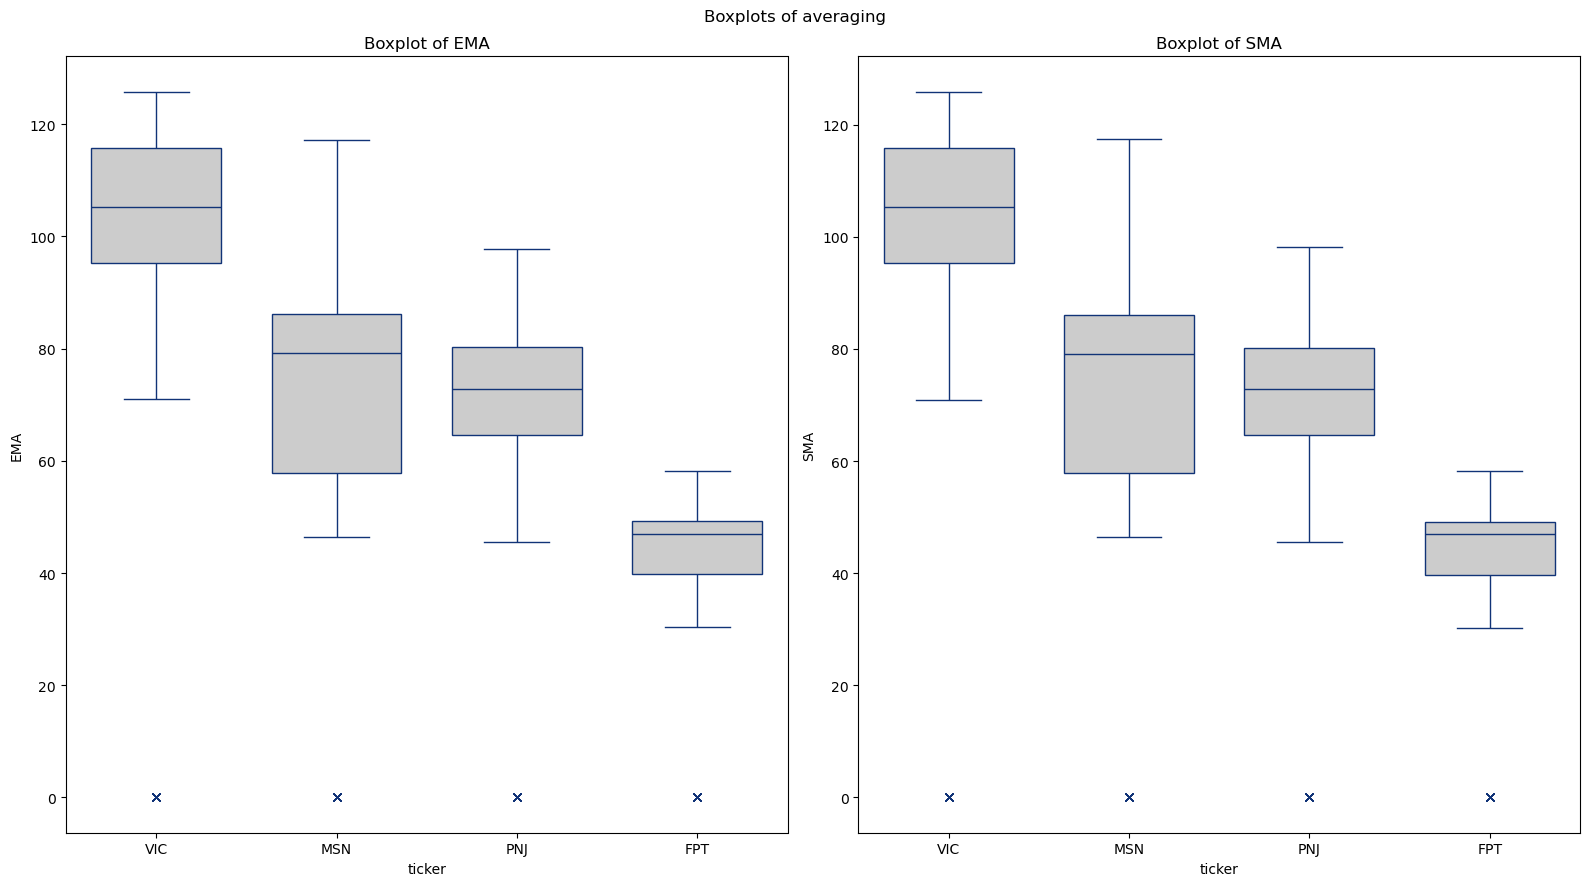

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1,figsize= (16,9), sharex='row',layout='tight')
fig.suptitle('Boxplots of averaging')
axes[0].set_title('Boxplot of EMA')
axes[1].set_title('Boxplot of SMA')
sb.boxplot(dataset.df, y='EMA',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[0])
_ = sb.boxplot(dataset.df, y='SMA',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[1])

### Boxplot types of price of each ticker

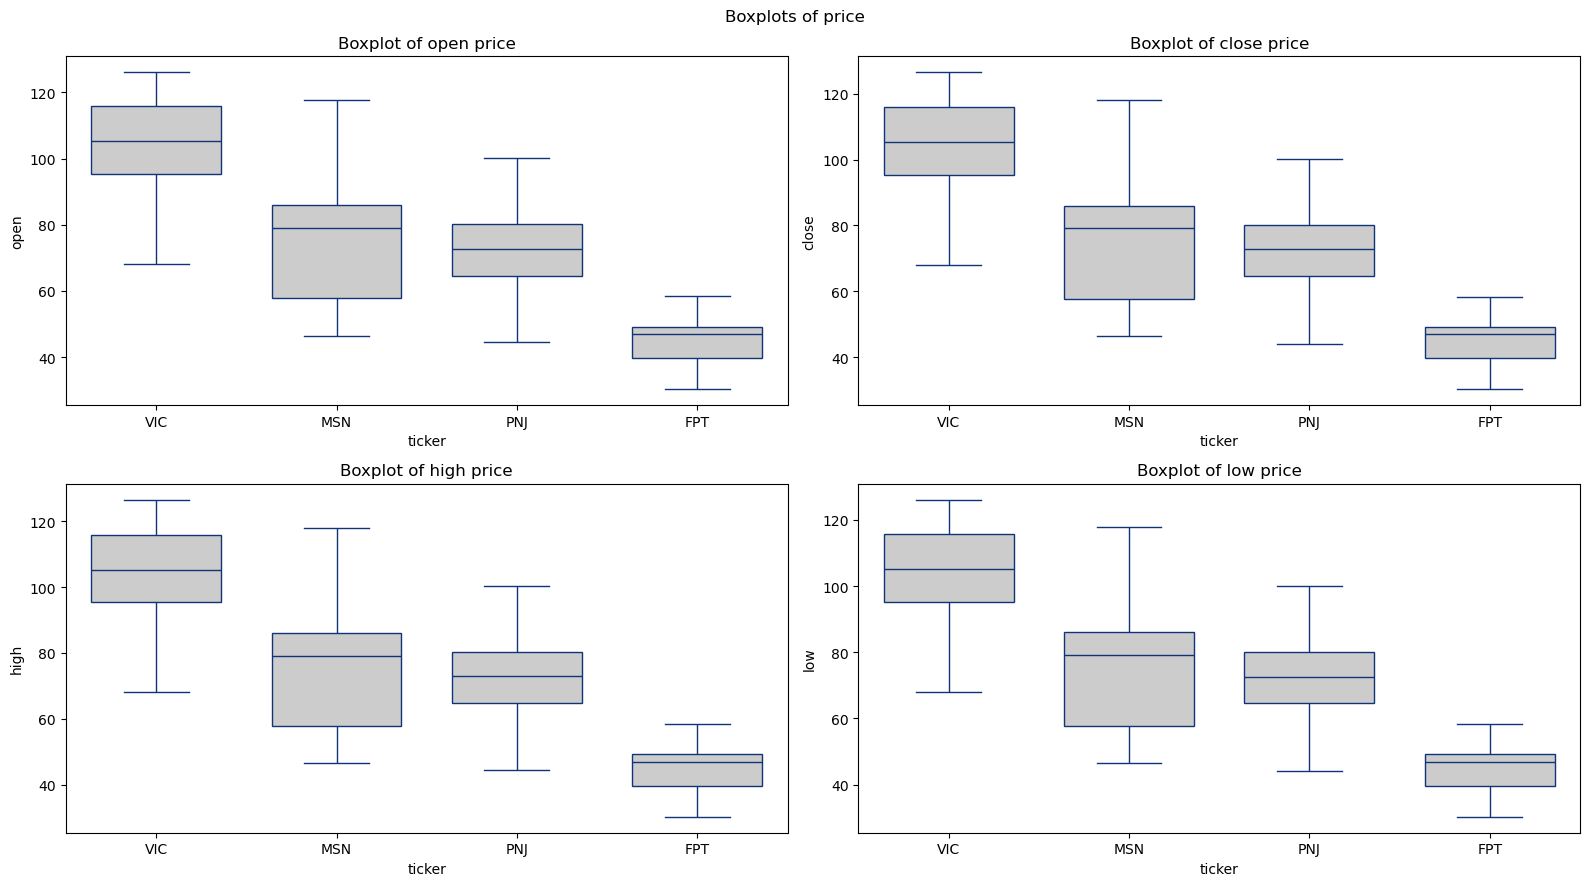

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=2,figsize= (16,9), sharex='row',layout='tight')
fig.suptitle('Boxplots of price')
axes[0,0].set_title('Boxplot of open price')
axes[0,1].set_title('Boxplot of close price')
axes[1,0].set_title('Boxplot of high price')
axes[1,1].set_title('Boxplot of low price')
sb.boxplot(dataset.df, y='open',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[0,0])
sb.boxplot(dataset.df, y='close',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[0,1])
sb.boxplot(dataset.df, y='high',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[1,0])
_ = sb.boxplot(dataset.df, y='low',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[1,1])

### Plot volume of each ticker

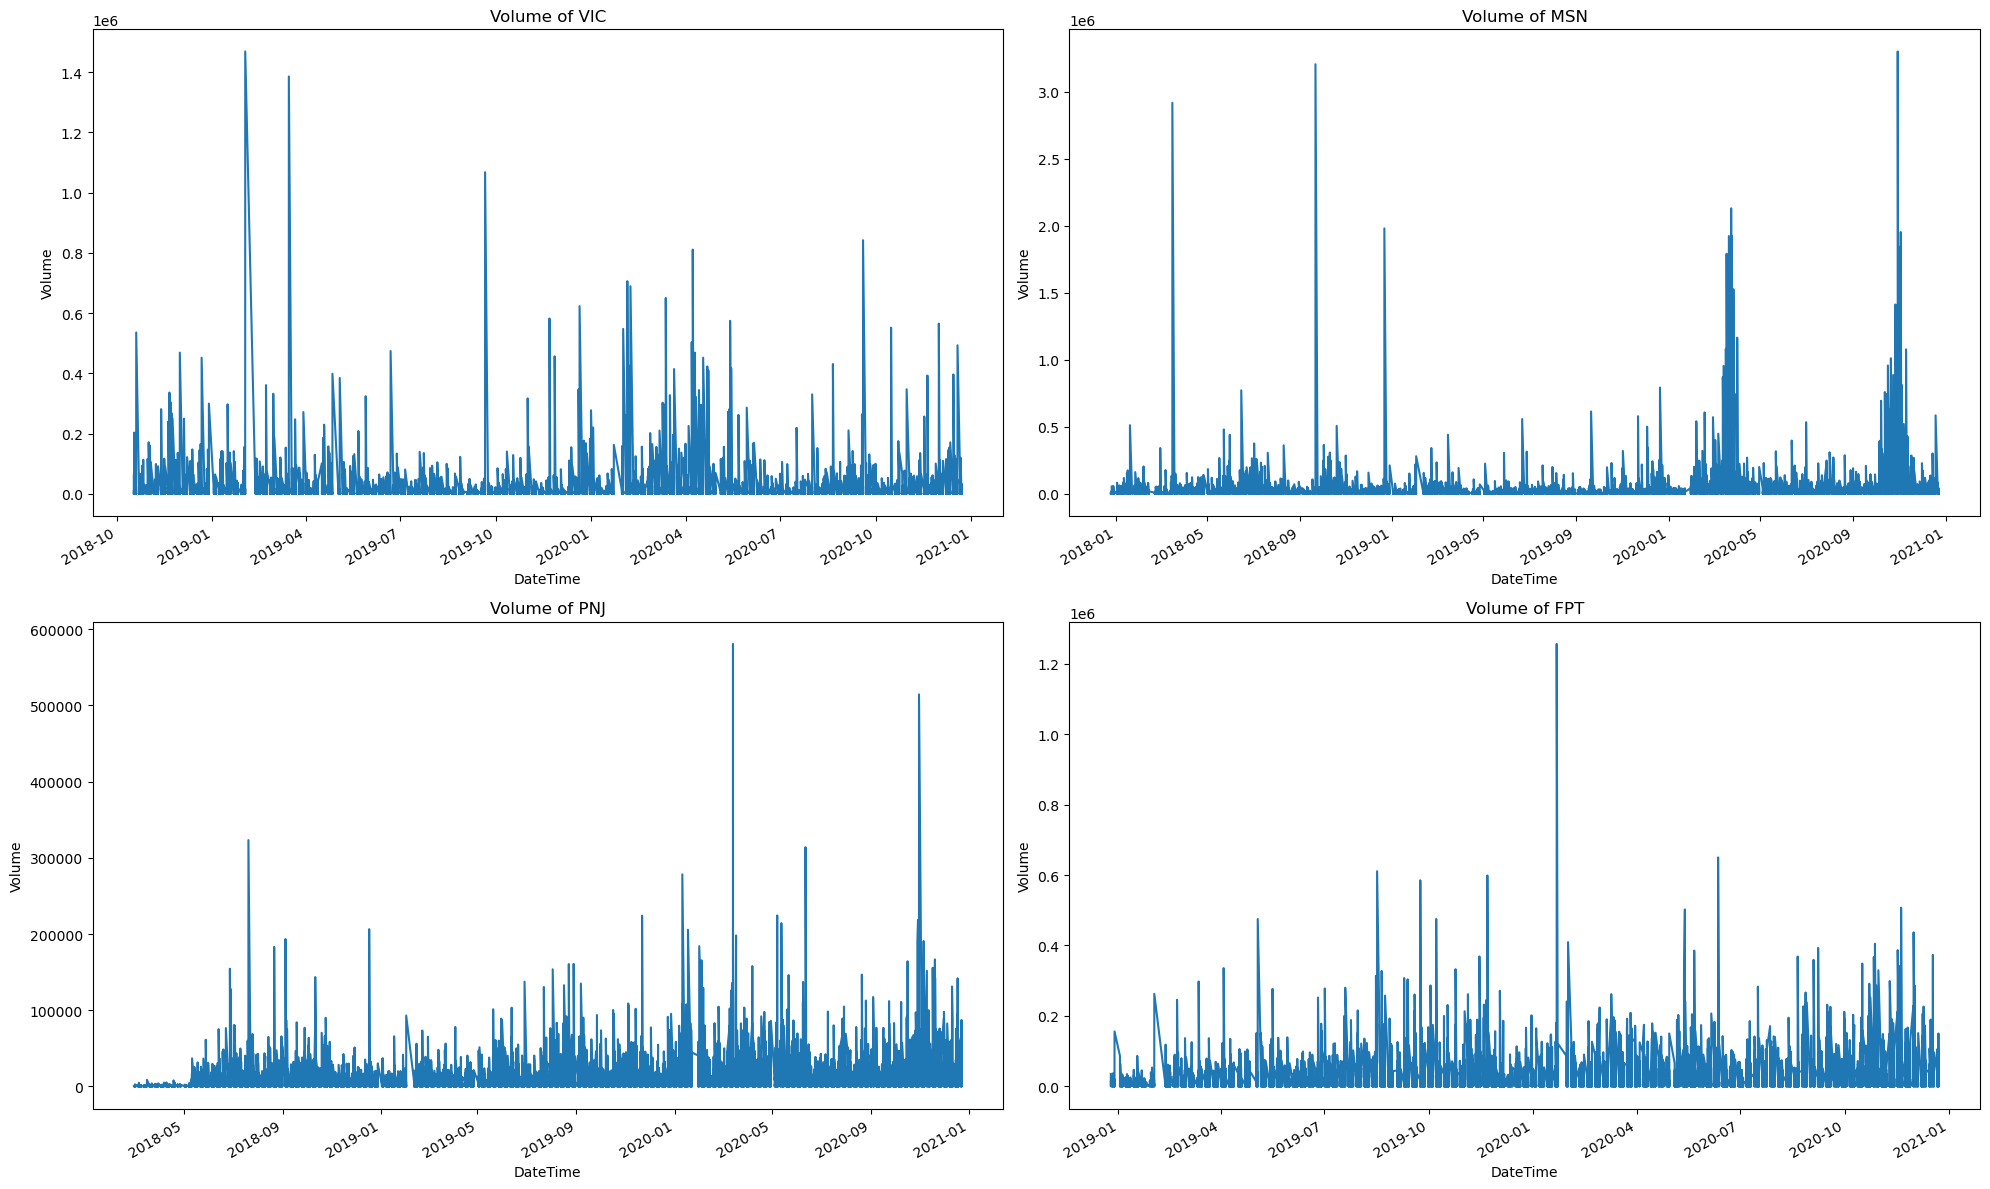

In [10]:
plt.figure(figsize=(20, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 2, i)
    index = dataset.df['ticker'] == ticker
    dataset.df.loc[index, 'volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel('DateTime')
    plt.title(f"Volume of {ticker}")
    
plt.tight_layout()

### Boxplot of volume and clipped volume for each ticker

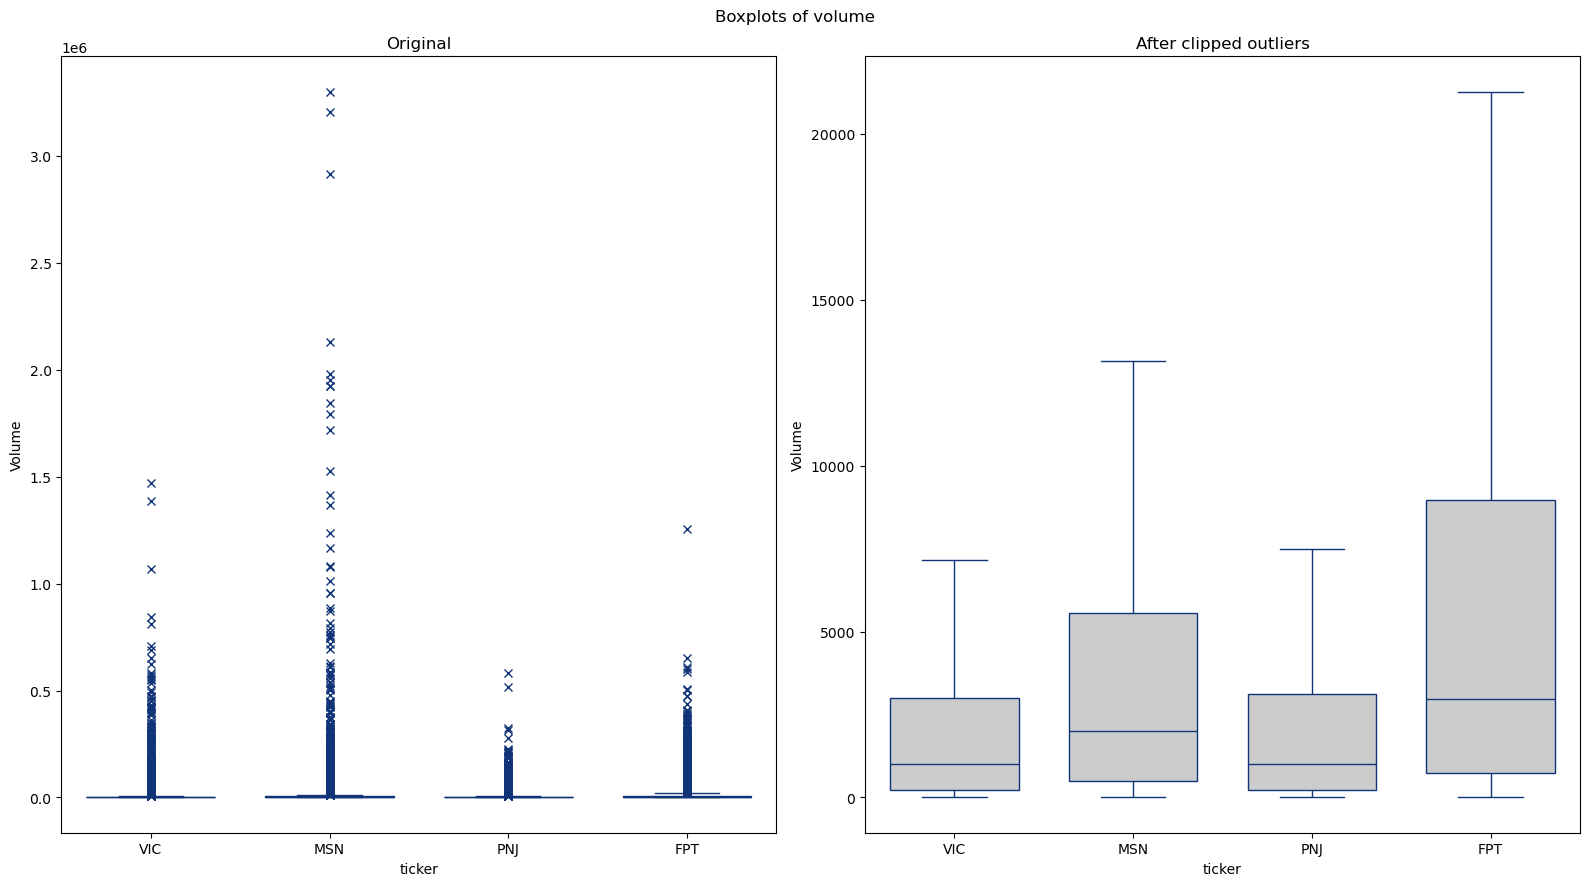

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1,figsize= (16,9), sharex='row',layout='tight')
fig.suptitle('Boxplots of volume')
axes[0].set_title('Original')
axes[0].set_ylabel('Volume')
axes[1].set_title('After clipped outliers')
axes[1].set_ylabel('Volume')
sb.boxplot(dataset.df, y='volume',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[0])
_ = sb.boxplot(dataset.df, y='clipped_volume',x='ticker',log_scale=None, fill=True,gap=0.1, color='.8',linecolor='#137',flierprops={"marker": "x"},ax=axes[1])

### Plot return for each ticker

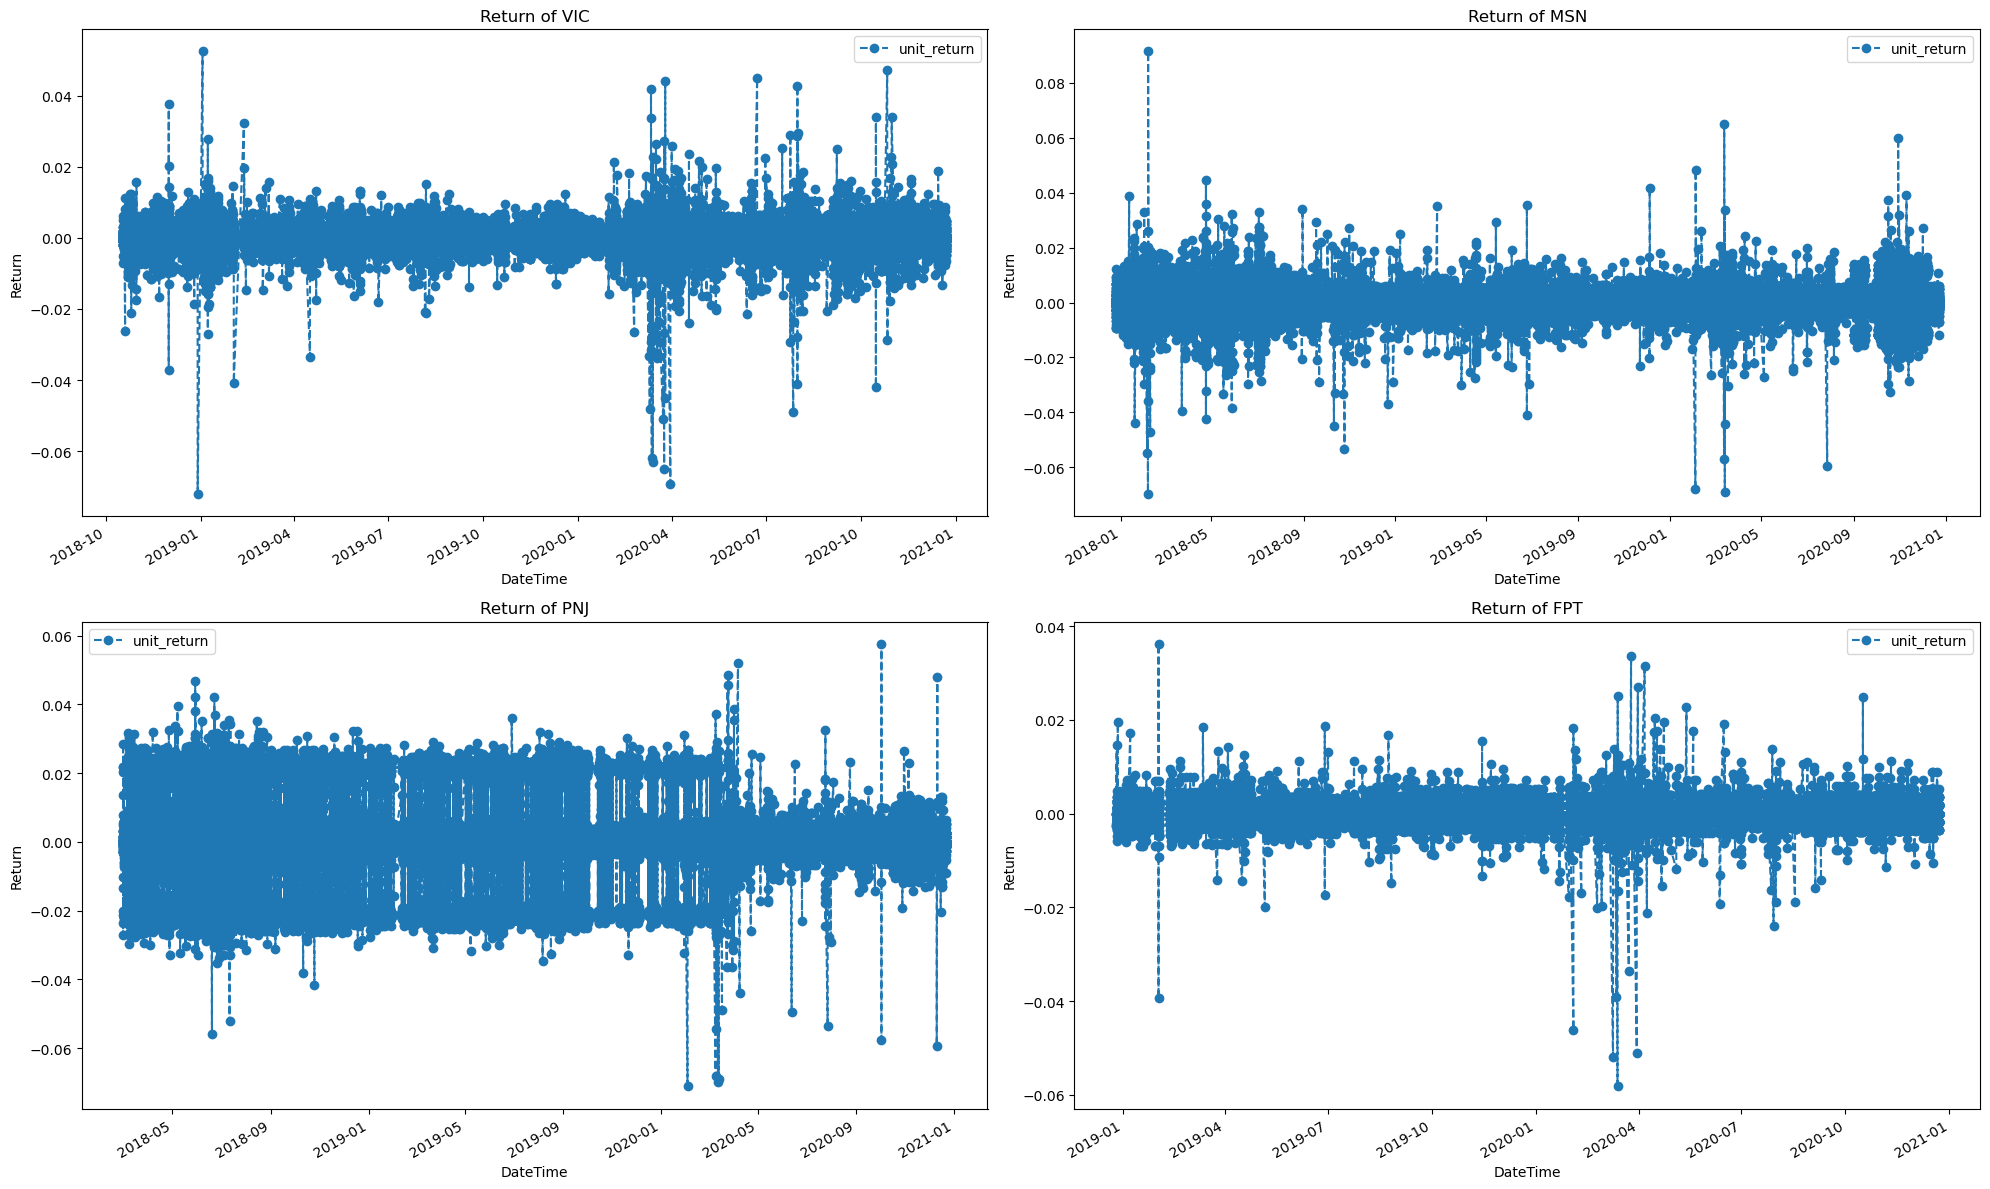

In [12]:
plt.figure(figsize=(20, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 2, i)
    index = dataset.df['ticker'] == ticker
    dataset.df.loc[index, 'unit_return'].plot(legend=True, linestyle='--', marker='o')
    plt.ylabel('Return')
    plt.xlabel('DateTime')
    plt.title(f"Return of {ticker}")
    
plt.tight_layout()

### Histogram of return for each ticker

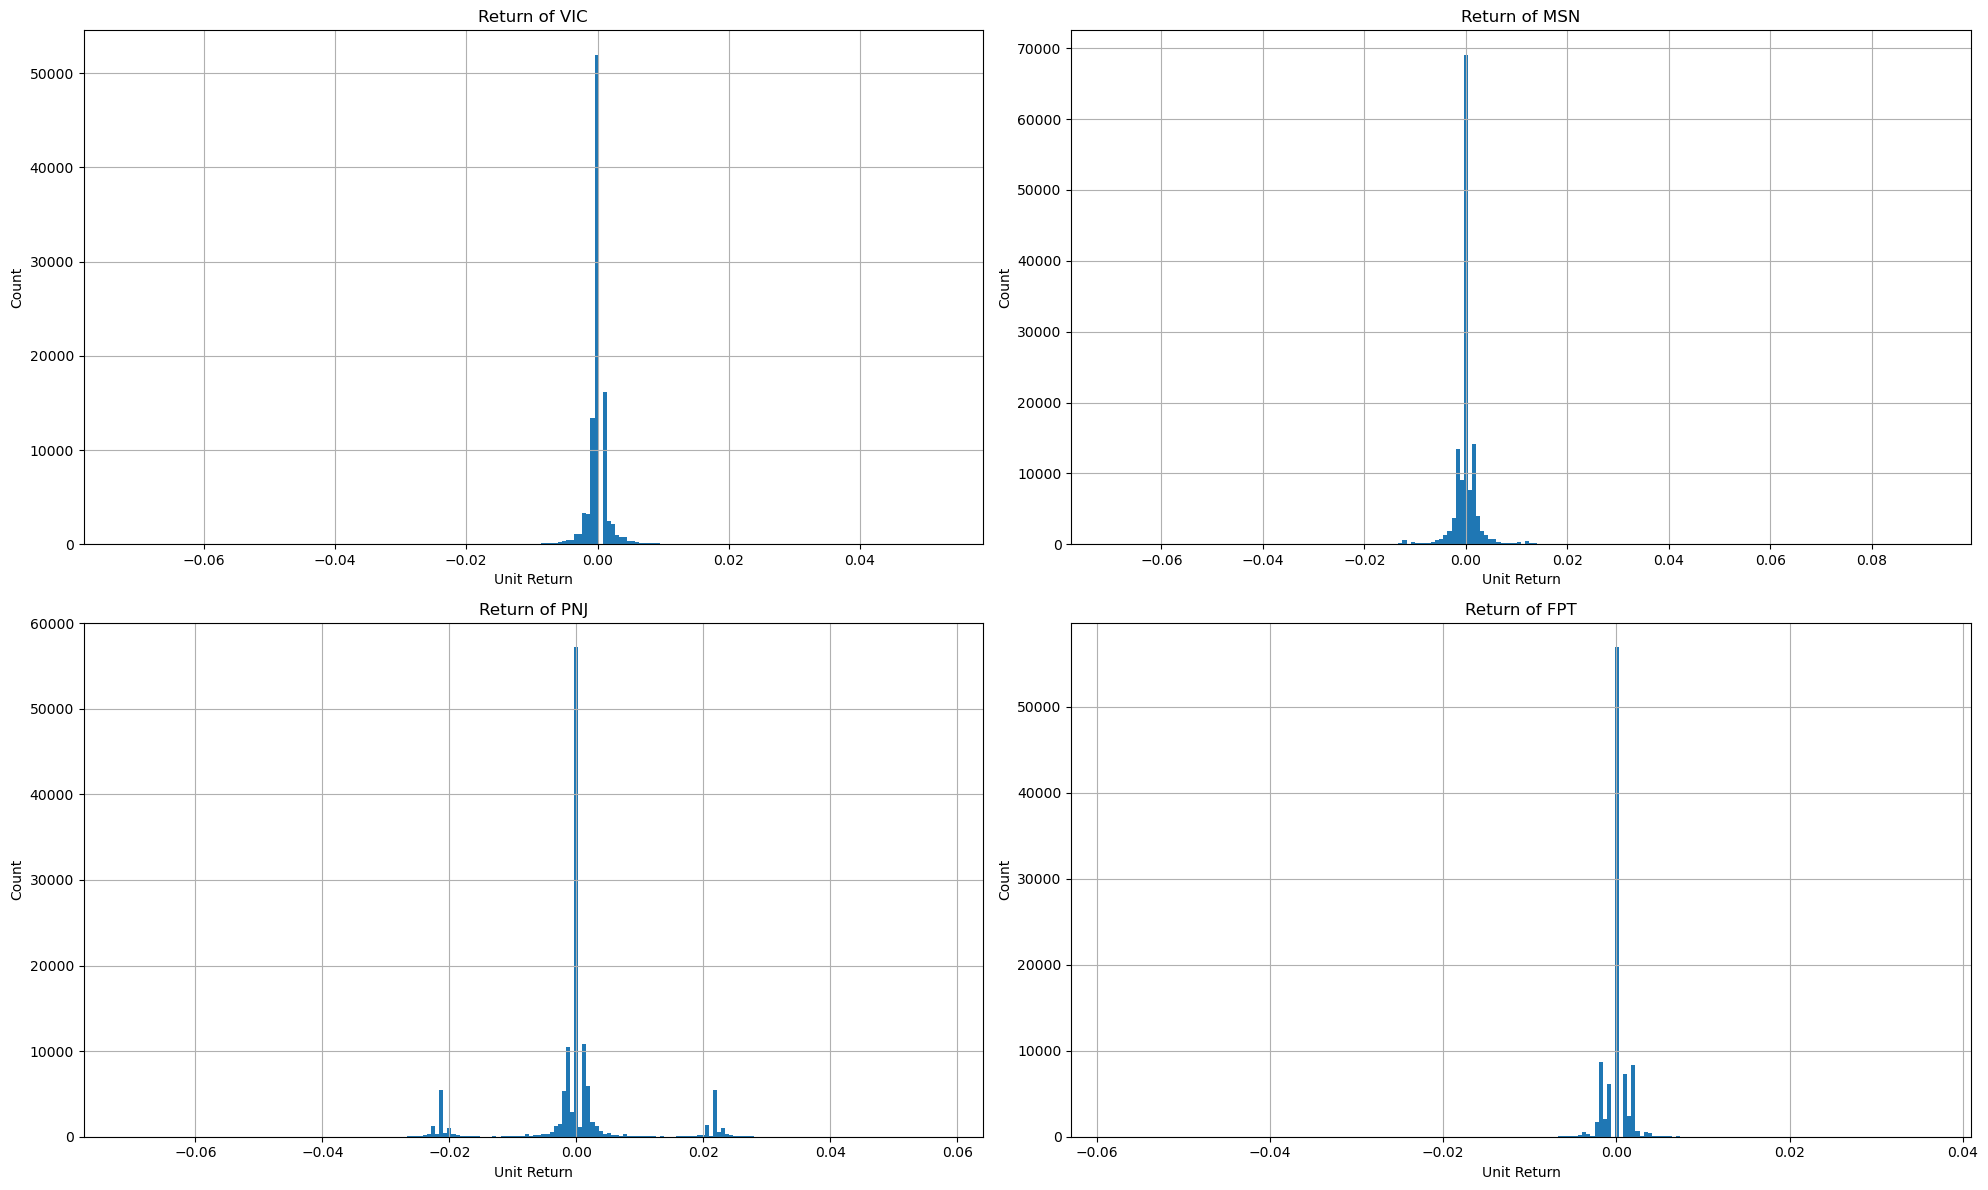

In [13]:
plt.figure(figsize=(20, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 2, i)
    index = dataset.df['ticker'] == ticker
    dataset.df.loc[index, 'unit_return'].hist(bins=200)
    plt.ylabel('Count')
    plt.xlabel('Unit Return')
    plt.title(f"Return of {ticker}")
    
plt.tight_layout()

### Plot correlation between price and close price

#### FPT

<Axes: title={'center': 'Open to Close'}, xlabel='open', ylabel='close'>

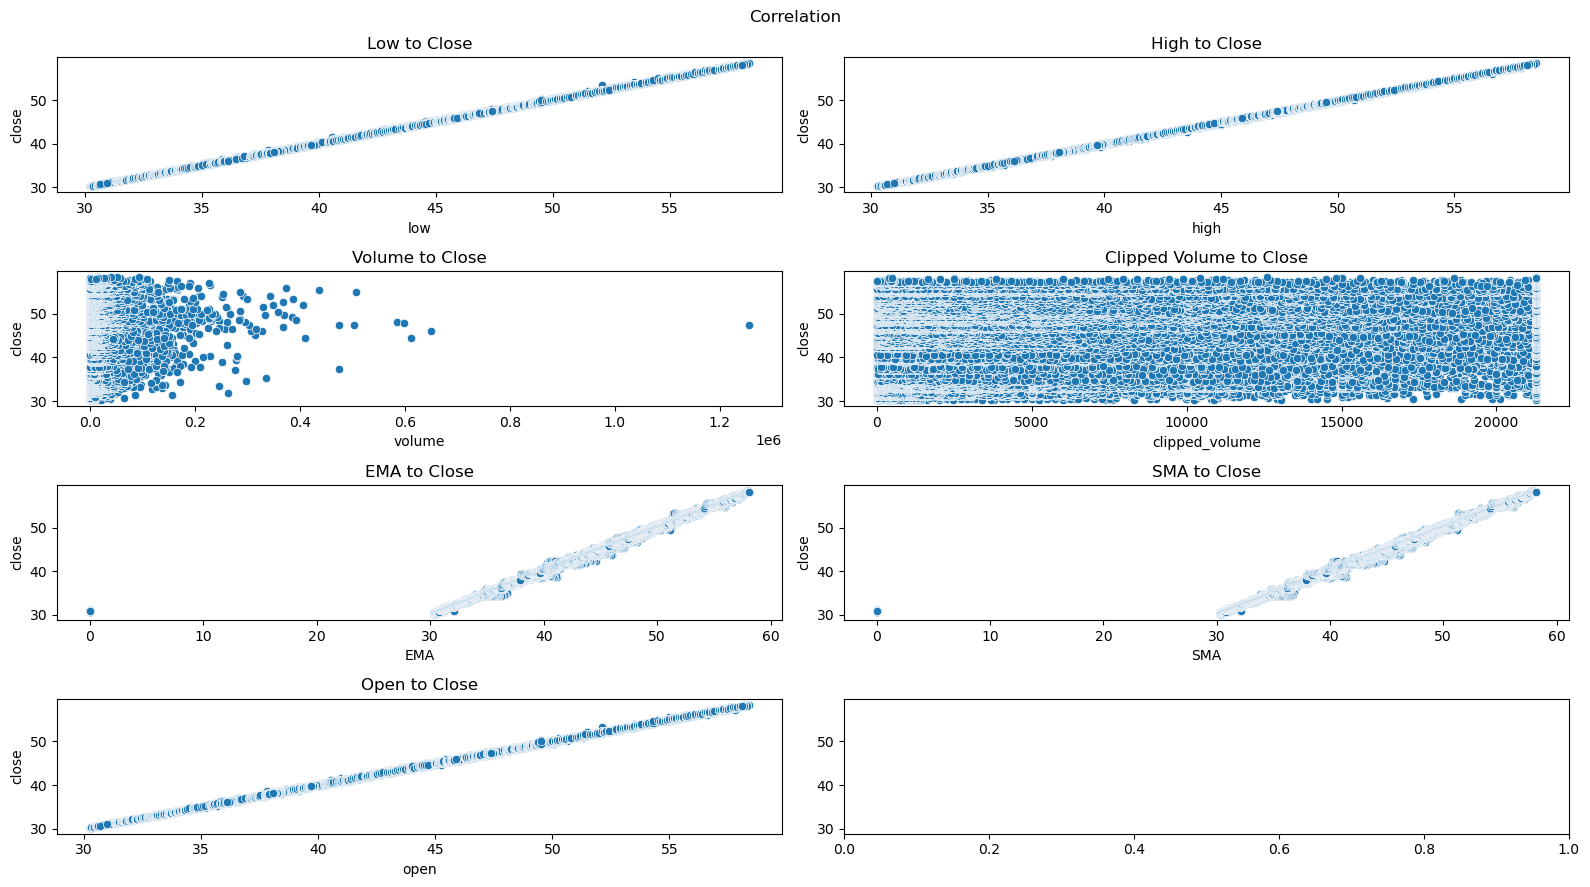

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize= (16,9), sharey='col',layout='tight')
fig.suptitle('Correlation')
axes[0,0].set_title('Low to Close')
axes[0,1].set_title('High to Close')
axes[1,0].set_title('Volume to Close')
axes[1,1].set_title('Clipped Volume to Close')
axes[2,0].set_title('EMA to Close')
axes[2,1].set_title('SMA to Close')
axes[3,0].set_title('Open to Close')
sub_df = dataset.df[dataset.df['ticker'] == 'FPT']
sb.scatterplot(data=sub_df,x='low',y='close',ax=axes[0,0])
sb.scatterplot(data=sub_df,x='high',y='close',ax=axes[0,1])
sb.scatterplot(data=sub_df,x='volume',y='close',ax=axes[1,0])
sb.scatterplot(data=sub_df,x='clipped_volume',y='close',ax=axes[1,1])
sb.scatterplot(data=sub_df,x='EMA',y='close',ax=axes[2,0])
sb.scatterplot(data=sub_df,x='SMA',y='close',ax=axes[2,1])
_ = sb.scatterplot(data=sub_df,x='open',y='close',ax=axes[3,0])


#### MSN

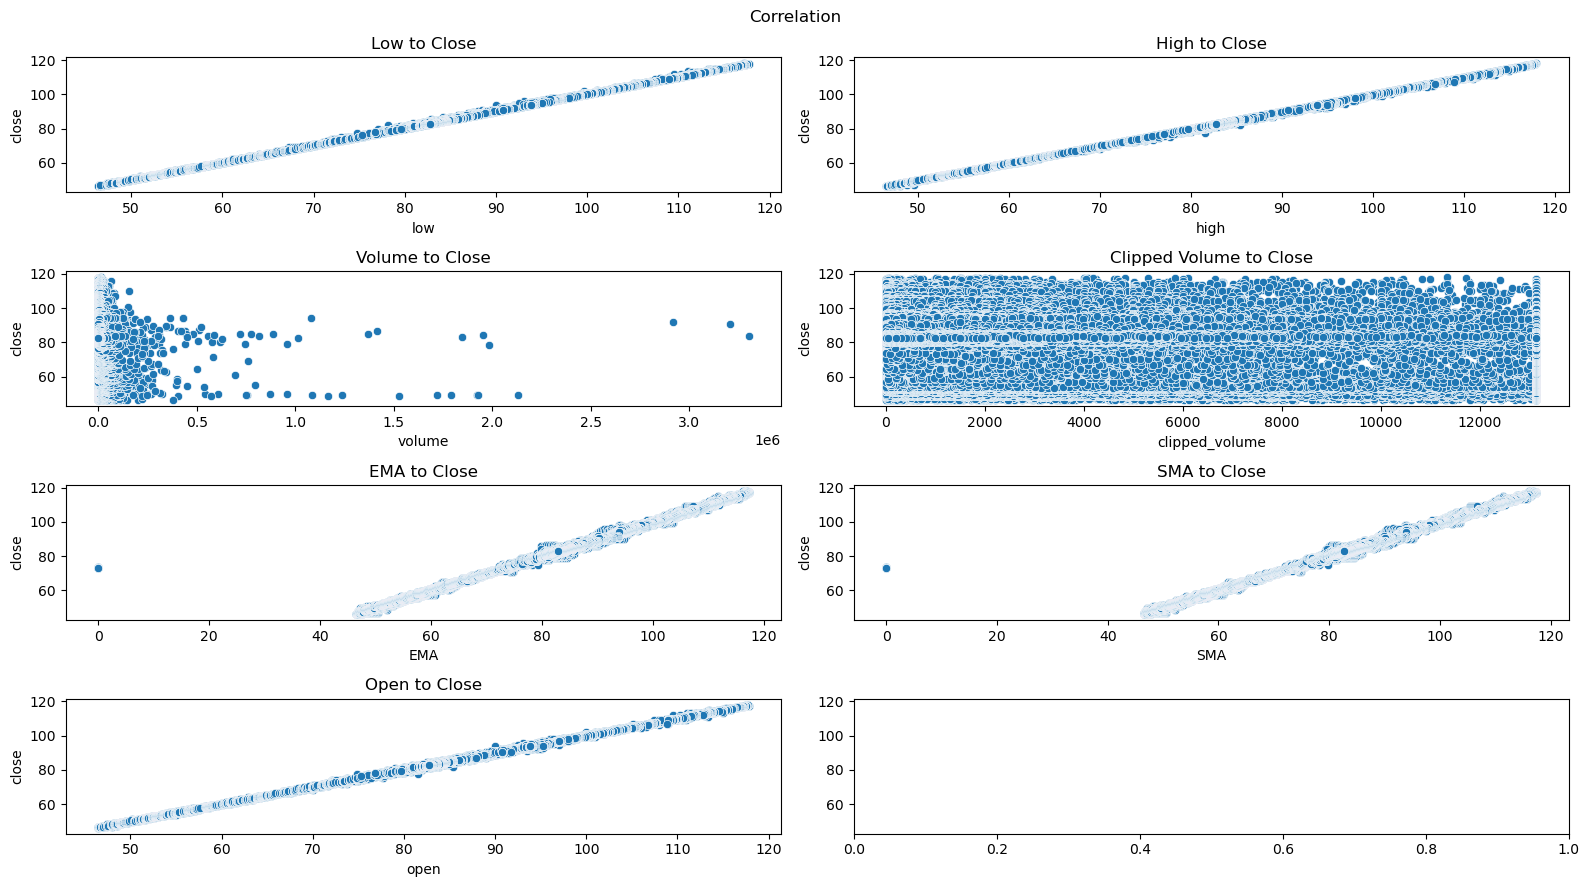

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize= (16,9), sharey='col',layout='tight')
fig.suptitle('Correlation')
axes[0,0].set_title('Low to Close')
axes[0,1].set_title('High to Close')
axes[1,0].set_title('Volume to Close')
axes[1,1].set_title('Clipped Volume to Close')
axes[2,0].set_title('EMA to Close')
axes[2,1].set_title('SMA to Close')
axes[3,0].set_title('Open to Close')
sub_df = dataset.df[dataset.df['ticker'] == 'MSN']
sb.scatterplot(data=sub_df,x='low',y='close',ax=axes[0,0])
sb.scatterplot(data=sub_df,x='high',y='close',ax=axes[0,1])
sb.scatterplot(data=sub_df,x='volume',y='close',ax=axes[1,0])
sb.scatterplot(data=sub_df,x='clipped_volume',y='close',ax=axes[1,1])
sb.scatterplot(data=sub_df,x='EMA',y='close',ax=axes[2,0])
sb.scatterplot(data=sub_df,x='SMA',y='close',ax=axes[2,1])
_ = sb.scatterplot(data=sub_df,x='open',y='close',ax=axes[3,0])


#### PNJ

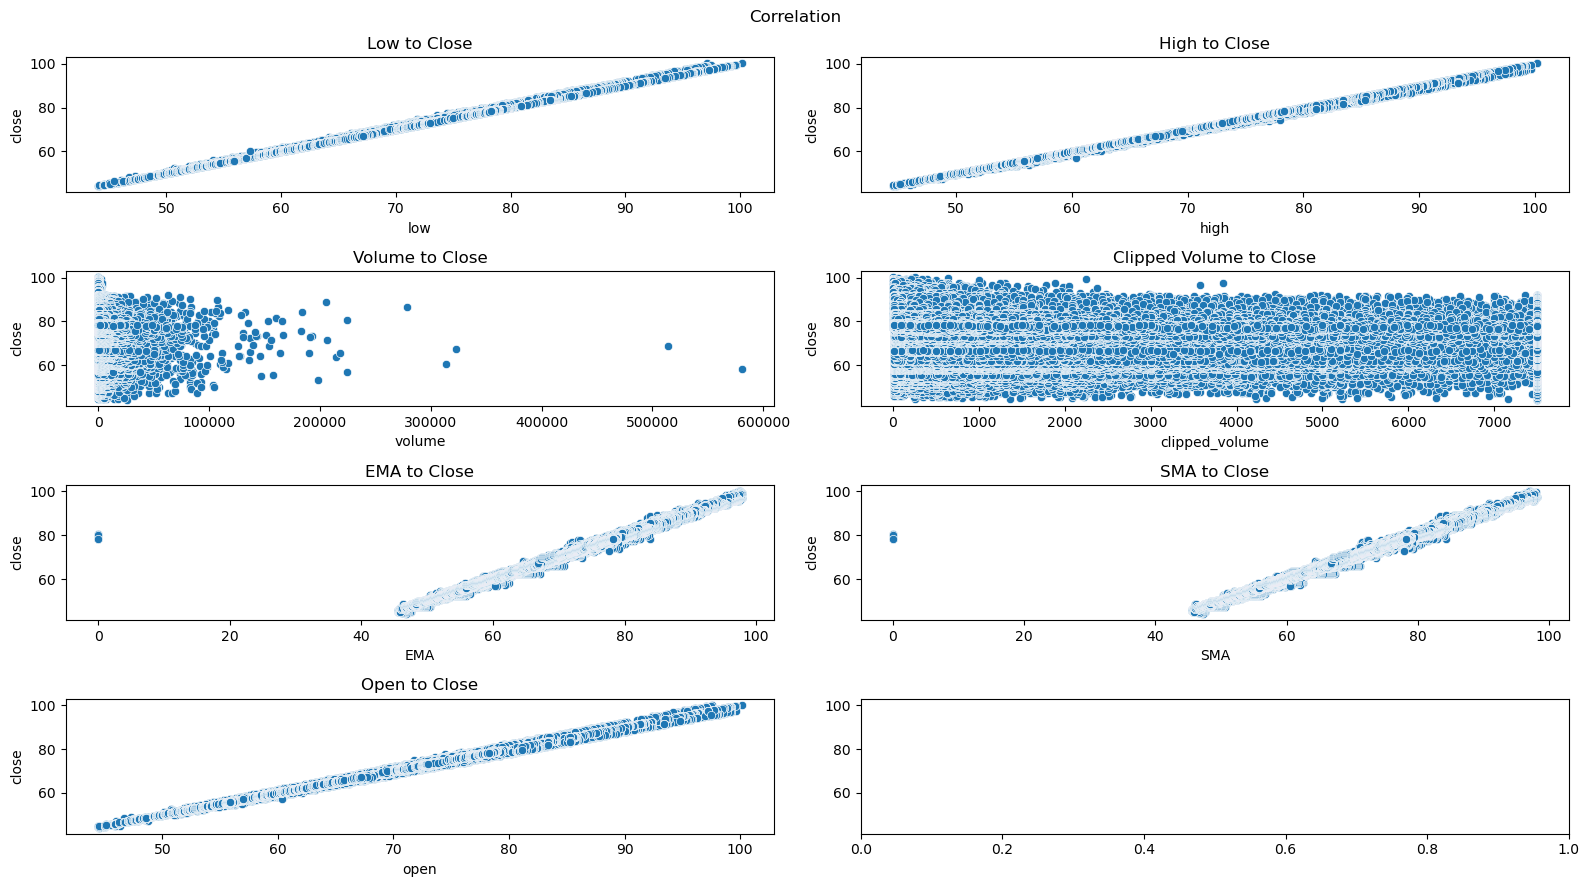

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize= (16,9), sharey='col',layout='tight')
fig.suptitle('Correlation')
axes[0,0].set_title('Low to Close')
axes[0,1].set_title('High to Close')
axes[1,0].set_title('Volume to Close')
axes[1,1].set_title('Clipped Volume to Close')
axes[2,0].set_title('EMA to Close')
axes[2,1].set_title('SMA to Close')
axes[3,0].set_title('Open to Close')
sub_df = dataset.df[dataset.df['ticker'] == 'PNJ']
sb.scatterplot(data=sub_df,x='low',y='close',ax=axes[0,0])
sb.scatterplot(data=sub_df,x='high',y='close',ax=axes[0,1])
sb.scatterplot(data=sub_df,x='volume',y='close',ax=axes[1,0])
sb.scatterplot(data=sub_df,x='clipped_volume',y='close',ax=axes[1,1])
sb.scatterplot(data=sub_df,x='EMA',y='close',ax=axes[2,0])
sb.scatterplot(data=sub_df,x='SMA',y='close',ax=axes[2,1])
_ = sb.scatterplot(data=sub_df,x='open',y='close',ax=axes[3,0])


#### VIC

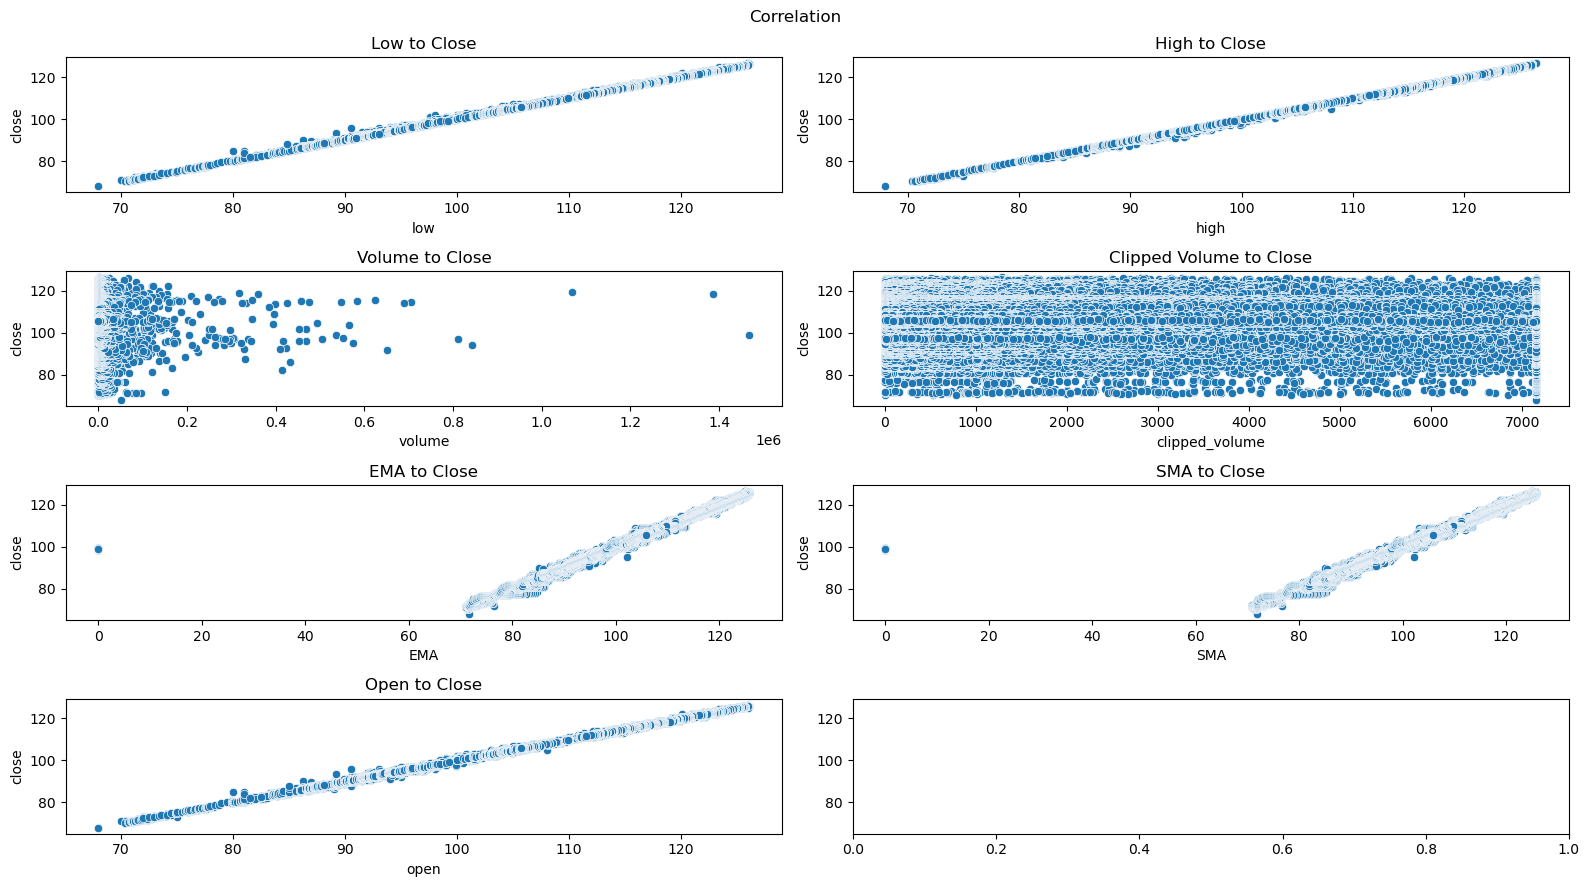

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize= (16,9), sharey='col',layout='tight')
fig.suptitle('Correlation')
axes[0,0].set_title('Low to Close')
axes[0,1].set_title('High to Close')
axes[1,0].set_title('Volume to Close')
axes[1,1].set_title('Clipped Volume to Close')
axes[2,0].set_title('EMA to Close')
axes[2,1].set_title('SMA to Close')
axes[3,0].set_title('Open to Close')
sub_df = dataset.df[dataset.df['ticker'] == 'VIC']
sb.scatterplot(data=sub_df,x='low',y='close',ax=axes[0,0])
sb.scatterplot(data=sub_df,x='high',y='close',ax=axes[0,1])
sb.scatterplot(data=sub_df,x='volume',y='close',ax=axes[1,0])
sb.scatterplot(data=sub_df,x='clipped_volume',y='close',ax=axes[1,1])
sb.scatterplot(data=sub_df,x='EMA',y='close',ax=axes[2,0])
sb.scatterplot(data=sub_df,x='SMA',y='close',ax=axes[2,1])
_ = sb.scatterplot(data=sub_df,x='open',y='close',ax=axes[3,0])


### Plot price with EMA, SMA in candlesticks

In [27]:
def display_stock_plot(df: pd.DataFrame, ticker: str):

    sub_df = copy(df[df['ticker'] == ticker])
    sub_df.loc[sub_df['EMA'] == 0, 'EMA'] = pd.NA
    sub_df.loc[sub_df['SMA'] == 0, 'SMA'] = pd.NA
    ema = fplt.make_addplot(sub_df["EMA"], color="orange", width=1)
    sma = fplt.make_addplot(sub_df["SMA"], color="dodgerblue", width=1)

    fplt.plot(
        sub_df,
        type='candle',
        addplot=[ema, sma],
        style='binance',
        title=f'{ticker}',
        ylabel='Price (VND)',
        volume=True,
        figratio=(200,110),
        tight_layout=True,
        show_nontrading=False,
        warn_too_much_data=1000000,
        #savefig={'fname' : f'../visualization/{ticker.lower()}_plot.png', 'dpi': 100, 'pad_inches': 0.25},
    )
    fplt.show()

#### FPT

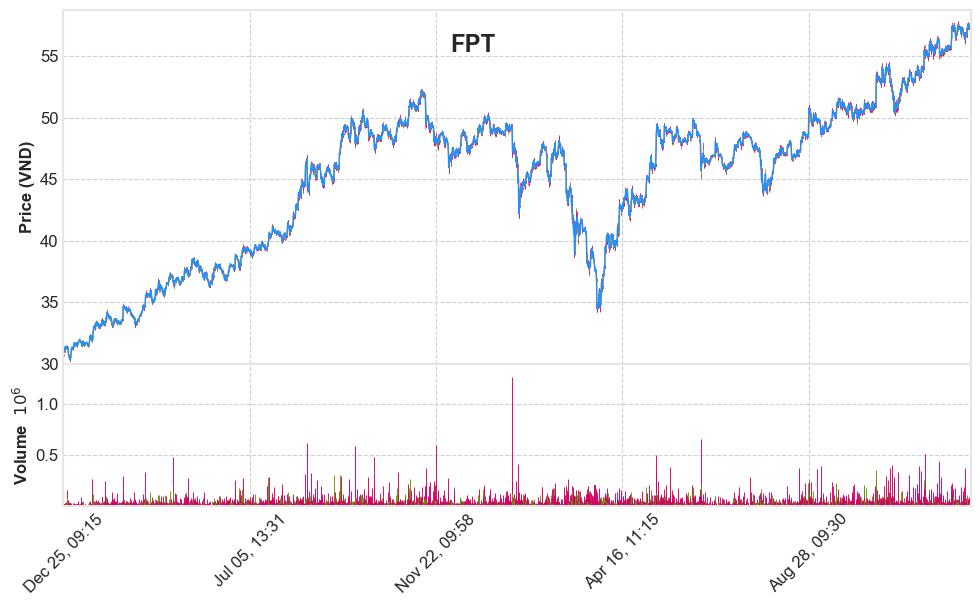

In [28]:
display_stock_plot(df=dataset.df,ticker='FPT')

#### VIC

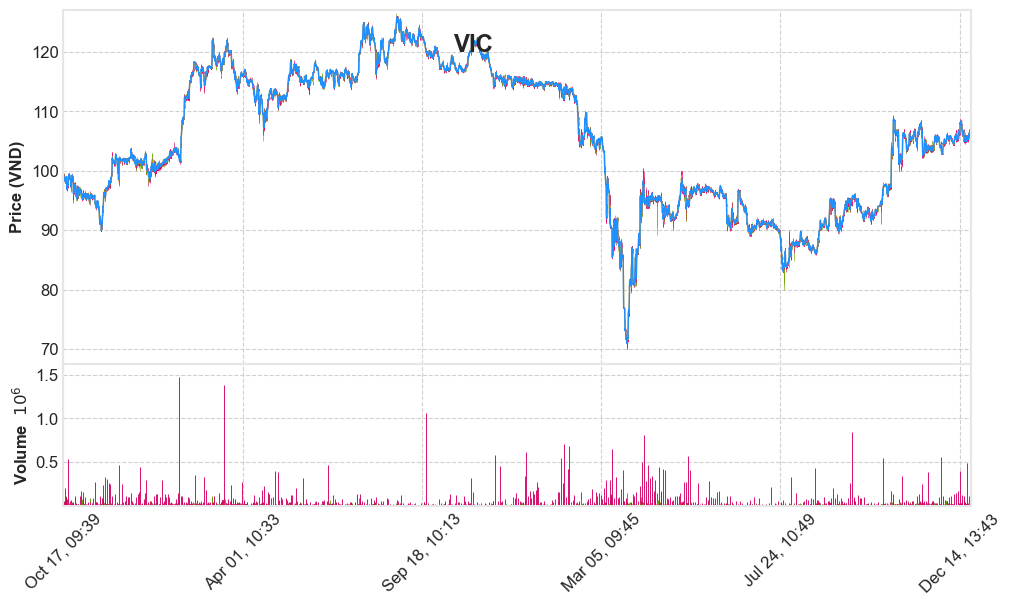

In [29]:
display_stock_plot(df=dataset.df,ticker='VIC')

#### PNJ

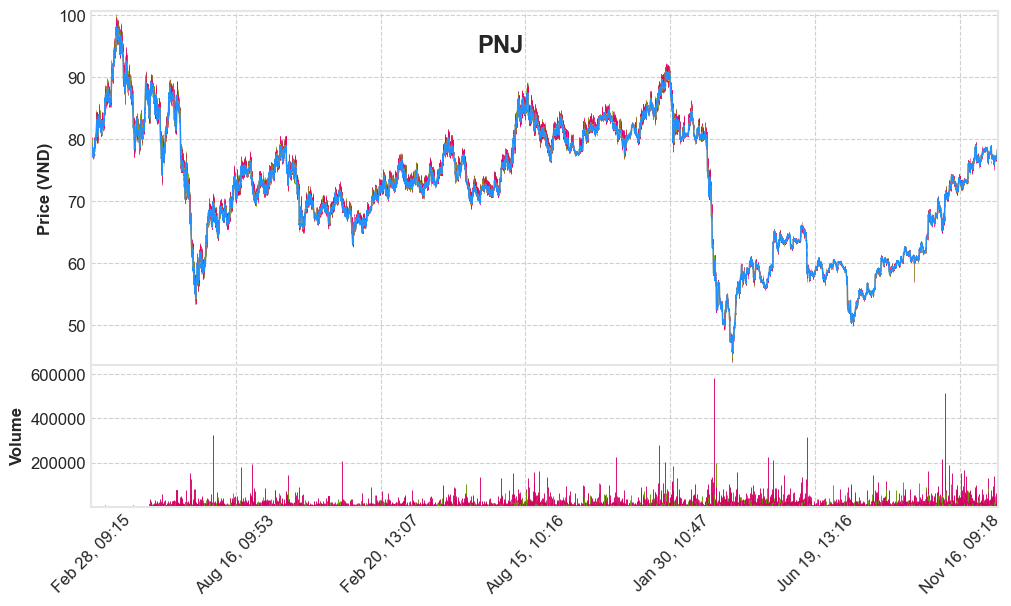

In [30]:
display_stock_plot(df=dataset.df,ticker='PNJ')

#### MSN

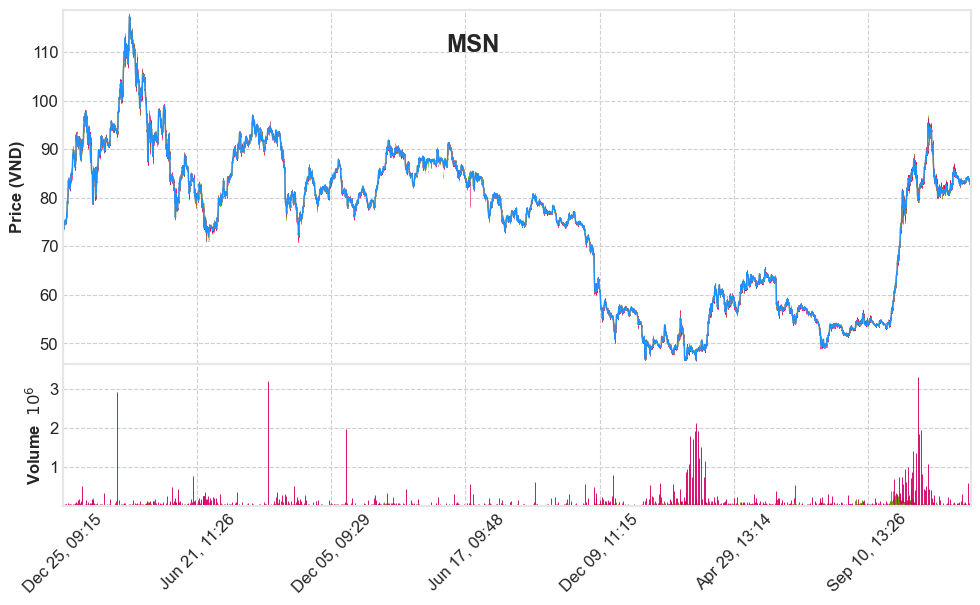

In [31]:
display_stock_plot(df=dataset.df,ticker='MSN')

## Define Hyper-parameters

In [26]:
BATCH_SIZE = 8
EPOCHS = 5
LR = 0.001
train_ratio = 0.8
val_ratio = 0.1

## Split dataset into train, val and test set as well as Dataloader for each set

In [27]:
train_set, val_set, test_set = dataset.split(train_ratio=train_ratio, val_ratio=val_ratio)
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE,drop_last=False,shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE,drop_last=False,shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE,drop_last=False,shuffle=True)

## Initialize Model

In [28]:
model_config = VolatilityPredictorConfig()
model = VolatilityPredictor(config=model_config)

## About Model

In [29]:
model

VolatilityPredictor(
  (up_projection): Linear(in_features=6, out_features=12, bias=True)
  (relu1): ReLU()
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (down_projection): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (final_projection): Linear(in_features=32, out_features=1, bias=True)
)

In [30]:
for m in model.named_modules():
    print(m)

('', VolatilityPredictor(
  (up_projection): Linear(in_features=6, out_features=12, bias=True)
  (relu1): ReLU()
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (down_projection): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (final_projection): Linear(in_features=32, out_features=1, bias=True)
))
('up_projection', Linear(in_features=6, out_features=12, bias=True))
('relu1', ReLU())
('lstm', LSTM(12, 64, num_layers=2, batch_first=True))
('down_projection', Linear(in_features=64, out_features=32, bias=True))
('relu2', ReLU())
('final_projection', Linear(in_features=32, out_features=1, bias=True))


## Initialize loss function, optimizer and writer path

In [31]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(params=model.parameters(),lr=LR)

writer_path = 'runs/volatility'

## Initialize Trainer

In [35]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader, 
    loss_fn=loss_fn,
    optimizer=optimizer,
    writer_path=writer_path
)

## Train Model

In [36]:
trainer.run(epoch=5)

EPOCH 1:
 batch 1000 loss: 562.9460433044434
 batch 2000 loss: 558.5253092041015
 batch 3000 loss: 563.3486133594513
 batch 4000 loss: 568.4558778533935
 batch 5000 loss: 436.7491211147308
 batch 6000 loss: 346.56338930892946
 batch 7000 loss: 339.67189632320407
 batch 8000 loss: 324.26036100673673
 batch 9000 loss: 321.3969802093506
 batch 10000 loss: 314.6295750398636
 batch 11000 loss: 330.4282258834839
 batch 12000 loss: 310.53905180358885
 batch 13000 loss: 313.7493638343811
 batch 14000 loss: 317.3899955596924
 batch 15000 loss: 315.6431291828155
 batch 16000 loss: 321.0273414344788
 batch 17000 loss: 316.14852860927584
 batch 18000 loss: 303.72568932628633
 batch 19000 loss: 305.17291846084595
 batch 20000 loss: 309.65313116455076
 batch 21000 loss: 309.90824135875704
 batch 22000 loss: 310.6491283426285
 batch 23000 loss: 308.2722678756714
 batch 24000 loss: 303.219674955368
 batch 25000 loss: 297.1407294063568
 batch 26000 loss: 290.15082299804686
 batch 27000 loss: 290.435294

In [ ]:
from torch.utils.tensorboard import SummaryWriter
# Launch TensorBoard to monitor training phase.

# Discussion

****